### Import necessary libraries

In [2]:
from collections import defaultdict
import os
import pickle
import sys
import timeit

import numpy as np

from rdkit import Chem
from rdkit.Chem import rdDepictor, Descriptors
from rdkit.Chem import MACCSkeys

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from sklearn.metrics import accuracy_score, precision_score, recall_score

### Check if GPU is available

In [3]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

print(device)

cpu


### Helper functions

In [4]:
# dictionary of atoms where a new element gets a new index
def create_atoms(mol):
    atoms = [atom_dict[a.GetSymbol()] for a in mol.GetAtoms()]
    return np.array(atoms)

# format from_atomIDx : [to_atomIDx, bondDict]
def create_ijbonddict(mol):
    i_jbond_dict = defaultdict(lambda: [])
    for b in mol.GetBonds():
        i, j = b.GetBeginAtomIdx(), b.GetEndAtomIdx()
        bond = bond_dict[str(b.GetBondType())]
        i_jbond_dict[i].append((j, bond))
        i_jbond_dict[j].append((i, bond))
    return i_jbond_dict


def create_fingerprints(atoms, i_jbond_dict, radius):
    """Extract the r-radius subgraphs (i.e., fingerprints)
    from a molecular graph using WeisfeilerLehman-like algorithm."""

    if (len(atoms) == 1) or (radius == 0):
        fingerprints = [fingerprint_dict[a] for a in atoms]

    else:
        vertices = atoms
        for _ in range(radius):
            fingerprints = []
            for i, j_bond in i_jbond_dict.items():
                neighbors = [(vertices[j], bond) for j, bond in j_bond]
                fingerprint = (vertices[i], tuple(sorted(neighbors)))
                fingerprints.append(fingerprint_dict[fingerprint])
            vertices = fingerprints

    return np.array(fingerprints)


def create_adjacency(mol):
    adjacency  = Chem.GetAdjacencyMatrix(mol)
    n          = adjacency.shape[0]
    
    adjacency  = adjacency + np.eye(n)
    degree     = sum(adjacency)
    d_half     = np.sqrt(np.diag(degree))
    d_half_inv = np.linalg.inv(d_half)
    adjacency  = np.matmul(d_half_inv,np.matmul(adjacency,d_half_inv))
    return np.array(adjacency)


def dump_dictionary(dictionary, file_name):
    with open(file_name, 'wb') as f:
        pickle.dump(dict(dictionary), f)
        

def load_tensor(file_name, dtype):
    return [dtype(d).to(device) for d in np.load(file_name + '.npy', allow_pickle=True)]


def load_numpy(file_name):
    return np.load(file_name + '.npy', allow_pickle=True)


def load_pickle(file_name):
    with open(file_name, 'rb') as f:
        return pickle.load(f)


def shuffle_dataset(dataset, seed):
    np.random.seed(seed)
    np.random.shuffle(dataset)
    return dataset


def split_dataset(dataset, ratio):
    n = int(ratio * len(dataset))
    dataset_1, dataset_2 = dataset[:n], dataset[n:]
    return dataset_1, dataset_2

### Read data

In [5]:
radius = 2

with open('kegg_classes.txt', 'r') as f:
    data_list = f.read().strip().split('\n')
    
"""Exclude the data contains "." in the smiles, which correspond to non-bonds"""
data_list = list(filter(lambda x: '.' not in x.strip().split()[0], data_list))
N = len(data_list)

print('Total number of molecules : %d' %(N))

atom_dict = defaultdict(lambda: len(atom_dict))
bond_dict = defaultdict(lambda: len(bond_dict))
fingerprint_dict = defaultdict(lambda: len(fingerprint_dict))

Molecules, Adjacencies, Properties, MACCS_list = [], [], [], []

max_MolMR, min_MolMR     = -1000, 1000
max_MolLogP, min_MolLogP = -1000, 1000
max_MolWt, min_MolWt     = -1000, 1000
max_NumRotatableBonds, min_NumRotatableBonds = -1000, 1000
max_NumAliphaticRings, min_NumAliphaticRings = -1000, 1000
max_NumAromaticRings, min_NumAromaticRings   = -1000, 1000
max_NumSaturatedRings, min_NumSaturatedRings = -1000, 1000

for no, data in enumerate(data_list):
    
    print('/'.join(map(str, [no+1, N])))
    
    smiles, property_indices = data.strip().split('\t')
    property_s = property_indices.strip().split(',')
    
    property = np.zeros((1,11))
    for prop in property_s:
        property[0,int(prop)] = 1
        
    Properties.append(property)
    
    mol = Chem.MolFromSmiles(smiles)
    atoms = create_atoms(mol)
    i_jbond_dict = create_ijbonddict(mol)

    fingerprints = create_fingerprints(atoms, i_jbond_dict, radius)
    Molecules.append(fingerprints)
    
    adjacency = create_adjacency(mol)
    Adjacencies.append(adjacency)
    
    MACCS         = MACCSkeys.GenMACCSKeys(Chem.MolFromSmiles(smiles))
    MACCS_ids     = np.zeros((20,))
    MACCS_ids[0]  = Descriptors.MolMR(mol)
    MACCS_ids[1]  = Descriptors.MolLogP(mol)
    MACCS_ids[2]  = Descriptors.MolWt(mol)
    MACCS_ids[3]  = Descriptors.NumRotatableBonds(mol)
    MACCS_ids[4]  = Descriptors.NumAliphaticRings(mol)
    MACCS_ids[5]  = MACCS[108]
    MACCS_ids[6]  = Descriptors.NumAromaticRings(mol)
    MACCS_ids[7]  = MACCS[98]
    MACCS_ids[8]  = Descriptors.NumSaturatedRings(mol)
    MACCS_ids[9]  = MACCS[137]
    MACCS_ids[10] = MACCS[136]
    MACCS_ids[11] = MACCS[145]
    MACCS_ids[12] = MACCS[116]
    MACCS_ids[13] = MACCS[141]
    MACCS_ids[14] = MACCS[89]
    MACCS_ids[15] = MACCS[50]
    MACCS_ids[16] = MACCS[160]
    MACCS_ids[17] = MACCS[121]
    MACCS_ids[18] = MACCS[149]
    MACCS_ids[19] = MACCS[161]
    
    if max_MolMR < MACCS_ids[0]:
        max_MolMR = MACCS_ids[0]
    if min_MolMR > MACCS_ids[0]:
        min_MolMR = MACCS_ids[0]
        
    if max_MolLogP < MACCS_ids[1]:
        max_MolLogP = MACCS_ids[1]
    if min_MolLogP > MACCS_ids[1]:
        min_MolLogP = MACCS_ids[1]
        
    if max_MolWt < MACCS_ids[2]:
        max_MolWt = MACCS_ids[2]
    if min_MolWt > MACCS_ids[2]:
        min_MolWt = MACCS_ids[2]
        
    if max_NumRotatableBonds < MACCS_ids[3]:
        max_NumRotatableBonds = MACCS_ids[3]
    if min_NumRotatableBonds > MACCS_ids[3]:
        min_NumRotatableBonds = MACCS_ids[3]
        
    if max_NumAliphaticRings < MACCS_ids[4]:
        max_NumAliphaticRings = MACCS_ids[4]
    if min_NumAliphaticRings > MACCS_ids[4]:
        min_NumAliphaticRings = MACCS_ids[4]
        
    if max_NumAromaticRings < MACCS_ids[6]:
        max_NumAromaticRings = MACCS_ids[6]
    if min_NumAromaticRings > MACCS_ids[6]:
        min_NumAromaticRings = MACCS_ids[6]
    
    if max_NumSaturatedRings < MACCS_ids[8]:
        max_NumSaturatedRings = MACCS_ids[8]
    if min_NumSaturatedRings > MACCS_ids[8]:
        min_NumSaturatedRings = MACCS_ids[8]
    
    MACCS_list.append(MACCS_ids)

dir_input = ('pathway/input'+str(radius)+'/')
os.makedirs(dir_input, exist_ok=True)

for n in range(N):
    for b in range(20):
        if b==0:
            MACCS_list[n][b] = (MACCS_list[n][b]-min_MolMR)/(max_MolMR-min_MolMR)
        elif b==1:
            MACCS_list[n][b] = (MACCS_list[n][b]-min_MolLogP)/(max_MolMR-min_MolLogP)
        elif b==2:
            MACCS_list[n][b] = (MACCS_list[n][b]-min_MolWt)/(max_MolMR-min_MolWt)
        elif b==3:
            MACCS_list[n][b] = (MACCS_list[n][b]-min_NumRotatableBonds)/(max_MolMR-min_NumRotatableBonds)
        elif b==4:
            MACCS_list[n][b] = (MACCS_list[n][b]-min_NumAliphaticRings)/(max_MolMR-min_NumAliphaticRings)
        elif b==6:
            MACCS_list[n][b] = (MACCS_list[n][b]-min_NumAromaticRings)/(max_MolMR-min_NumAromaticRings)
        elif b==8:
            MACCS_list[n][b] = (MACCS_list[n][b]-min_NumSaturatedRings)/(max_NumSaturatedRings-min_NumSaturatedRings)

np.save(dir_input + 'molecules', Molecules)
np.save(dir_input + 'adjacencies', Adjacencies)
np.save(dir_input + 'properties', Properties)
np.save(dir_input + 'maccs', np.asarray(MACCS_list))

dump_dictionary(fingerprint_dict, dir_input + 'fingerprint_dict.pickle')

print('The preprocess has finished!')

Total number of molecules : 6669
1/6669
2/6669
3/6669
4/6669
5/6669
6/6669
7/6669
8/6669
9/6669
10/6669
11/6669
12/6669
13/6669
14/6669
15/6669
16/6669
17/6669
18/6669
19/6669
20/6669
21/6669
22/6669
23/6669
24/6669
25/6669
26/6669
27/6669
28/6669
29/6669
30/6669
31/6669
32/6669
33/6669
34/6669
35/6669
36/6669
37/6669
38/6669
39/6669
40/6669
41/6669
42/6669
43/6669
44/6669
45/6669
46/6669
47/6669
48/6669
49/6669
50/6669
51/6669
52/6669
53/6669
54/6669
55/6669
56/6669
57/6669
58/6669
59/6669
60/6669
61/6669
62/6669
63/6669
64/6669
65/6669
66/6669
67/6669
68/6669
69/6669
70/6669
71/6669
72/6669
73/6669
74/6669
75/6669
76/6669
77/6669
78/6669
79/6669
80/6669
81/6669
82/6669
83/6669
84/6669
85/6669
86/6669
87/6669
88/6669
89/6669
90/6669
91/6669
92/6669
93/6669
94/6669
95/6669
96/6669
97/6669
98/6669
99/6669
100/6669
101/6669
102/6669
103/6669
104/6669
105/6669
106/6669
107/6669
108/6669
109/6669
110/6669
111/6669
112/6669
113/6669
114/6669
115/6669
116/6669
117/6669
118/6669
119/6669
120/

[11:03:16] WARNING: not removing hydrogen atom without neighbors
[11:03:16] WARNING: not removing hydrogen atom without neighbors
[11:03:16] WARNING: not removing hydrogen atom without neighbors
[11:03:16] WARNING: not removing hydrogen atom without neighbors


746/6669
747/6669
748/6669
749/6669
750/6669
751/6669
752/6669
753/6669
754/6669
755/6669
756/6669
757/6669
758/6669
759/6669
760/6669
761/6669
762/6669
763/6669
764/6669
765/6669
766/6669
767/6669
768/6669
769/6669
770/6669
771/6669
772/6669
773/6669
774/6669
775/6669
776/6669
777/6669
778/6669
779/6669
780/6669
781/6669
782/6669
783/6669
784/6669
785/6669
786/6669
787/6669
788/6669
789/6669
790/6669
791/6669
792/6669
793/6669
794/6669
795/6669
796/6669
797/6669
798/6669
799/6669
800/6669
801/6669
802/6669
803/6669
804/6669
805/6669
806/6669
807/6669
808/6669
809/6669
810/6669
811/6669
812/6669
813/6669
814/6669
815/6669
816/6669
817/6669
818/6669
819/6669
820/6669
821/6669
822/6669
823/6669
824/6669
825/6669
826/6669
827/6669
828/6669
829/6669
830/6669
831/6669
832/6669
833/6669
834/6669
835/6669
836/6669
837/6669
838/6669
839/6669
840/6669
841/6669
842/6669
843/6669
844/6669
845/6669
846/6669
847/6669
848/6669
849/6669
850/6669
851/6669
852/6669
853/6669
854/6669
855/6669
856/6669
8

[11:03:16] WARNING: not removing hydrogen atom with dummy atom neighbors
[11:03:16] WARNING: not removing hydrogen atom with dummy atom neighbors
[11:03:17] WARNING: not removing hydrogen atom with dummy atom neighbors
[11:03:17] WARNING: not removing hydrogen atom with dummy atom neighbors


999/6669
1000/6669
1001/6669
1002/6669
1003/6669
1004/6669
1005/6669
1006/6669
1007/6669
1008/6669
1009/6669
1010/6669
1011/6669
1012/6669
1013/6669
1014/6669
1015/6669
1016/6669
1017/6669
1018/6669
1019/6669
1020/6669
1021/6669
1022/6669
1023/6669
1024/6669
1025/6669
1026/6669
1027/6669
1028/6669
1029/6669
1030/6669
1031/6669
1032/6669
1033/6669
1034/6669
1035/6669
1036/6669
1037/6669
1038/6669
1039/6669
1040/6669
1041/6669
1042/6669
1043/6669
1044/6669
1045/6669
1046/6669
1047/6669
1048/6669
1049/6669
1050/6669
1051/6669
1052/6669
1053/6669
1054/6669
1055/6669
1056/6669
1057/6669
1058/6669
1059/6669
1060/6669
1061/6669
1062/6669
1063/6669
1064/6669
1065/6669
1066/6669
1067/6669
1068/6669
1069/6669
1070/6669
1071/6669
1072/6669
1073/6669
1074/6669
1075/6669
1076/6669
1077/6669
1078/6669
1079/6669
1080/6669
1081/6669
1082/6669
1083/6669
1084/6669
1085/6669
1086/6669
1087/6669
1088/6669
1089/6669
1090/6669
1091/6669
1092/6669
1093/6669
1094/6669
1095/6669
1096/6669
1097/6669
1098/6669
1

c:\Users\Daniel\anaconda3\lib\site-packages\numpy\lib\npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


### Define a Neural Network class

In [6]:
class PathwayPredictor(nn.Module):
    
    def __init__(self):
        super(PathwayPredictor, self).__init__()
        self.embed_atom = nn.Embedding(n_fingerprint, dim)
        self.W_atom = nn.ModuleList([nn.Linear(dim, dim) for _ in range(layer)])
        self.W_property = nn.Linear(dim+extra_dim, 11)
    
    """Pad adjacency matrices for batch processing."""
    def pad(self, matrices, value):
        sizes = [d.shape[0] for d in matrices]
        D = sum(sizes)
        pad_matrices = value + np.zeros((D, D))
        m = 0
        for i, d in enumerate(matrices):
            s_i = sizes[i]
            pad_matrices[m:m+s_i, m:m+s_i] = d
            m += s_i
        return torch.FloatTensor(pad_matrices).to(device)
    
    def sum_axis(self, xs, axis):
        y = list(map(lambda x: torch.sum(x, 0), torch.split(xs, axis)))
        return torch.stack(y)
    
    def update(self, xs, adjacency, i):
        hs = torch.relu(self.W_atom[i](xs))
        return torch.matmul(adjacency, hs)
    
    def forward(self, inputs, sel_maccs):
        
        atoms, adjacency = inputs
        
        axis = list(map(lambda x: len(x), atoms))

        atoms = torch.cat(atoms)
        
        x_atoms = self.embed_atom(atoms)
        adjacency = self.pad(adjacency, 0)

        for i in range(layer):
            x_atoms = self.update(x_atoms, adjacency, i)
        
        extra_inputs = sel_maccs.to(device)
        y_molecules = self.sum_axis(x_atoms, axis)
        
        y_molecules = torch.cat((y_molecules,extra_inputs),1)
        z_properties = self.W_property(y_molecules)
        
        return z_properties
    
    def __call__(self, data_batch, train=True):
        
        sel_maccs = torch.FloatTensor(data_batch[-1])
        
        inputs, t_properties = data_batch[:-2], torch.cat(data_batch[-2])
        
        z_properties = self.forward(inputs, sel_maccs)
        
        if train:
            loss = F.binary_cross_entropy(torch.sigmoid(z_properties), t_properties)
            return loss
        else:
            zs = torch.sigmoid(z_properties).to('cpu').data.numpy()
            ts = t_properties.to('cpu').data.numpy()
            scores = list(map(lambda x: x, zs))
            labels = list(map(lambda x: (x>=0.5).astype(int), zs))
            return scores, labels, ts

### Create a trainer class

In [7]:
class Trainer(object):
    
    def __init__(self, model):
        self.model = model
        self.optimizer = optim.Adam(self.model.parameters(), lr=lr)
        
    def train(self, dataset_train):
        np.random.shuffle(dataset_train)
        N = len(dataset_train)
        loss_total = 0
        for i in range(0, N, batch):
            data_batch = list(zip(*dataset_train[i:i+batch]))
            loss = self.model(data_batch)
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()
            loss_total += loss.to('cpu').data.numpy()
        return loss_total

### Create a tester class

In [8]:
class Tester(object):
    
    def __init__(self, model):
        self.model = model

    def test(self, dataset_test):

        N = len(dataset_test)
        score_list, label_list, t_list = [], [], []

        for i in range(0, N, batch):
            data_batch = list(zip(*dataset_test[i:i+batch]))
            scores, labels, ts = self.model(data_batch, train=False)
            score_list = np.append(score_list, scores)
            label_list = np.append(label_list, labels)
            t_list = np.append(t_list, ts)
        
        auc       = accuracy_score(t_list, label_list)
        precision = precision_score(t_list, label_list)
        recall    = recall_score(t_list, label_list)
        
        return auc, precision, recall

### Model Hyperparameters

In [9]:
dim            = 70
layer          = 2
batch          = 10
lr             = 1e-3
lr_decay       = 0.75
decay_interval = 20
iteration      = 100
extra_dim      = 20

(dim, layer, batch, decay_interval, iteration, extra_dim) = map(int, [dim, layer, batch, decay_interval, iteration, extra_dim])
lr, lr_decay = map(float, [lr, lr_decay])

### Data preparation

In [10]:
dir_input = ('pathway/input'+str(radius)+'/')

molecules    = load_tensor(dir_input + 'molecules', torch.LongTensor)
adjacencies  = load_numpy(dir_input + 'adjacencies')
t_properties = load_tensor(dir_input + 'properties', torch.FloatTensor)
maccs        = load_numpy(dir_input + 'maccs')

with open(dir_input + 'fingerprint_dict.pickle', 'rb') as f:
    fingerprint_dict = pickle.load(f)
    
dataset = list(zip(molecules, adjacencies, t_properties, maccs))
dataset = shuffle_dataset(dataset, 1234)
dataset_train, dataset_   = split_dataset(dataset, 0.8)
dataset_dev, dataset_test = split_dataset(dataset_, 0.5)

fingerprint_dict = load_pickle(dir_input + 'fingerprint_dict.pickle')
unknown          = 100
n_fingerprint    = len(fingerprint_dict) + unknown

### Create and train model

In [12]:
torch.manual_seed(1234)

model   = PathwayPredictor().to(device)
trainer = Trainer(model)
tester  = Tester(model)

dir_output = ('pathway/output/')
os.makedirs(dir_output, exist_ok=True)

print('Training...')
print('Epoch \t Time(sec) \t Loss_train \t AUC_dev \t AUC_test \t Precision \t Recall')

start = timeit.default_timer()
loss_values = []
acc_values = []
epoch_values = []
true_labels = []
predicted_labels = []

for epoch in range(iteration):
    if (epoch+1) % decay_interval == 0:
        trainer.optimizer.param_groups[0]['lr'] *= lr_decay

    loss    = trainer.train(dataset_train)
    auc_dev = tester.test(dataset_dev)[0]
    auc_test, precision, recall = tester.test(dataset_test)
    acc_values.append(auc_test)
    loss_values.append(loss)
    epoch_values.append(epoch)
    lr_rate = trainer.optimizer.param_groups[0]['lr']

    end  = timeit.default_timer()
    time = end - start

    print('%d \t %.4f \t %.4f \t %.4f \t %.4f \t %.4f \t %.4f' %(epoch, time, loss, auc_dev, auc_test, precision, recall))

Training...
Epoch 	 Time(sec) 	 Loss_train 	 AUC_dev 	 AUC_test 	 Precision 	 Recall
0 	 2.6012 	 164.5164 	 0.8975 	 0.8878 	 0.7729 	 0.4716
1 	 5.1353 	 116.0814 	 0.9160 	 0.9045 	 0.7684 	 0.6183
2 	 7.7062 	 93.3881 	 0.9170 	 0.9085 	 0.8661 	 0.5397
3 	 10.2084 	 80.7327 	 0.9413 	 0.9313 	 0.8537 	 0.7139
4 	 12.8477 	 67.7625 	 0.9432 	 0.9339 	 0.8741 	 0.7091
5 	 15.3682 	 59.6454 	 0.9512 	 0.9433 	 0.8532 	 0.8006
6 	 17.9237 	 51.8183 	 0.9531 	 0.9449 	 0.8331 	 0.8412
7 	 20.4264 	 46.1782 	 0.9541 	 0.9498 	 0.8492 	 0.8533
8 	 23.0267 	 40.5495 	 0.9547 	 0.9538 	 0.8978 	 0.8185
9 	 25.8459 	 37.3387 	 0.9554 	 0.9503 	 0.8392 	 0.8712
10 	 28.2841 	 33.9347 	 0.9595 	 0.9562 	 0.8471 	 0.9028
11 	 30.6083 	 31.1663 	 0.9617 	 0.9577 	 0.8909 	 0.8533
12 	 32.9742 	 29.4866 	 0.9613 	 0.9594 	 0.8939 	 0.8606
13 	 35.3524 	 27.3329 	 0.9646 	 0.9616 	 0.8742 	 0.9011
14 	 37.7030 	 25.7415 	 0.9636 	 0.9642 	 0.8778 	 0.9141
15 	 40.1588 	 24.2204 	 0.9597 	 0.9599 

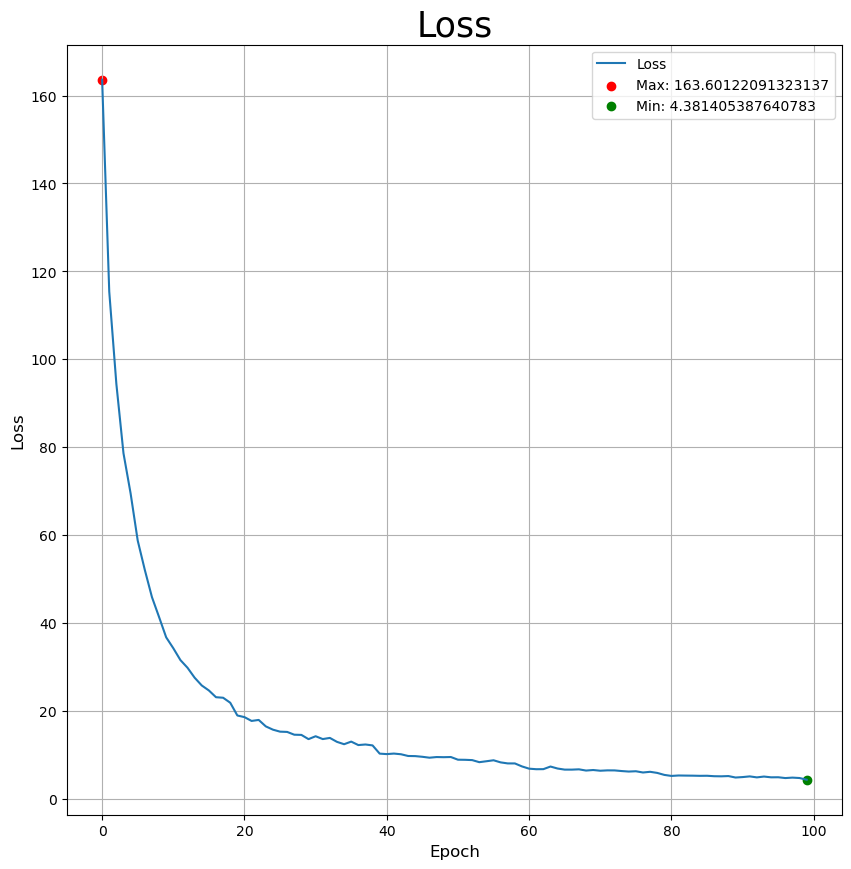

In [45]:

import matplotlib.pyplot as plt

max_index = loss_values.index(max(loss_values))
min_index = loss_values.index(min(loss_values))

plt.figure(figsize=(10, 10))
plt.plot(epoch_values, loss_values, label='Loss')
plt.scatter(epoch_values[max_index], loss_values[max_index], c='red', label=f'Max: {loss_values[max_index]}')
plt.scatter(epoch_values[min_index], loss_values[min_index], c='green', label=f'Min: {loss_values[min_index]}')
plt.title("Loss", fontsize=25)
plt.xlabel("Epoch", fontsize=12)
plt.ylabel("Loss", fontsize=12)
plt.grid()
plt.legend()
plt.show()



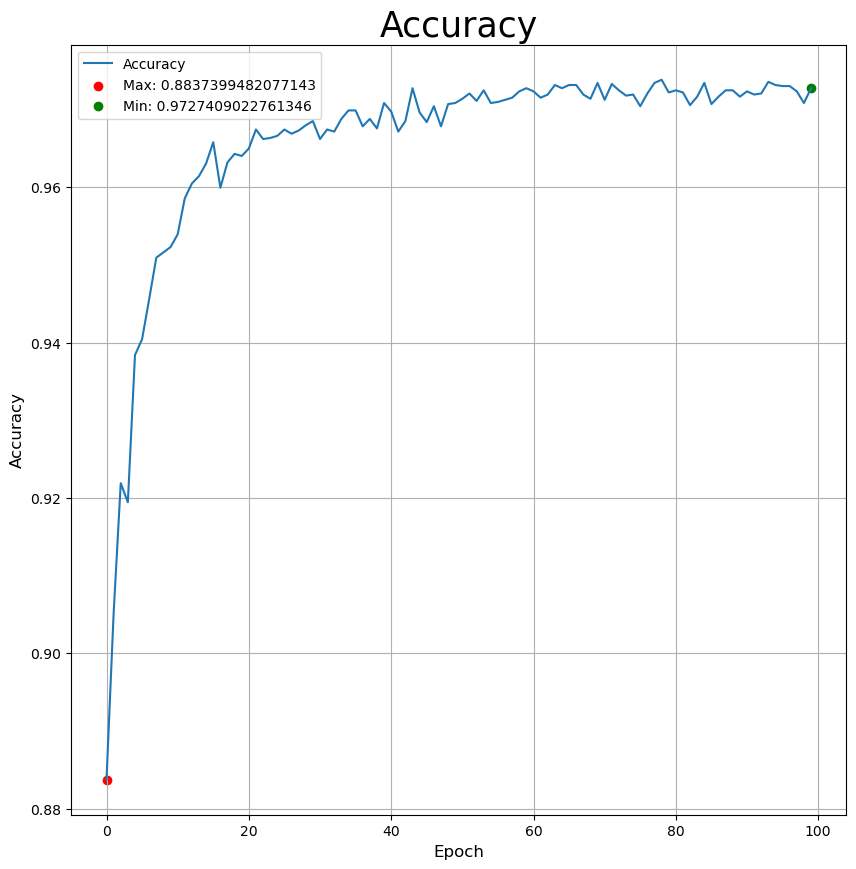

In [46]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
plt.plot(epoch_values, acc_values, label='Accuracy')
plt.scatter(epoch_values[max_index], acc_values[max_index], c='red', label=f'Max: {acc_values[max_index]}')
plt.scatter(epoch_values[min_index], acc_values[min_index], c='green', label=f'Min: {acc_values[min_index]}')
plt.title("Accuracy", fontsize=25)
plt.xlabel("Epoch", fontsize=12)
plt.ylabel("Accuracy", fontsize=12)
plt.grid()
plt.legend()
plt.show()


### Class-wise evaluation

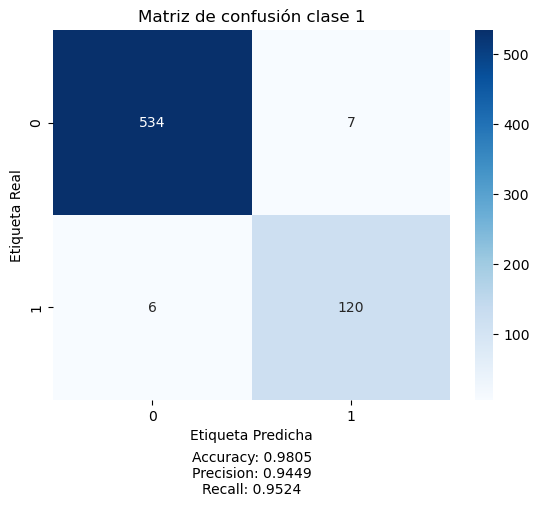

Class 1 statistics:
Accuracy 0.9805, Precision 0.9449, Recall 0.9524



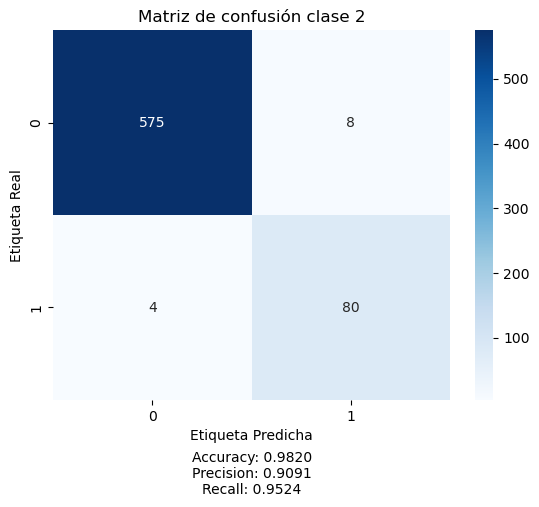

Class 2 statistics:
Accuracy 0.9820, Precision 0.9091, Recall 0.9524



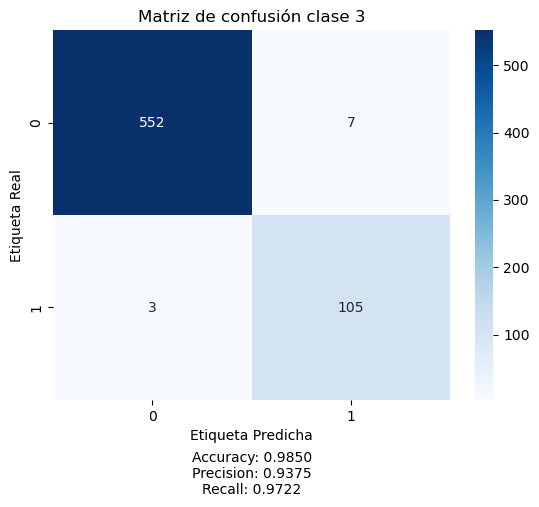

Class 3 statistics:
Accuracy 0.9850, Precision 0.9375, Recall 0.9722



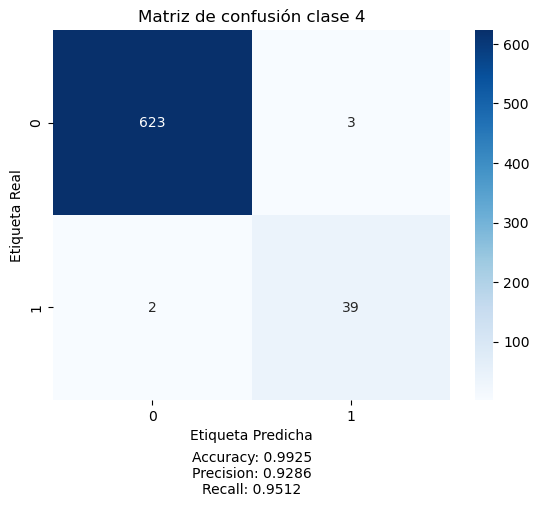

Class 4 statistics:
Accuracy 0.9925, Precision 0.9286, Recall 0.9512



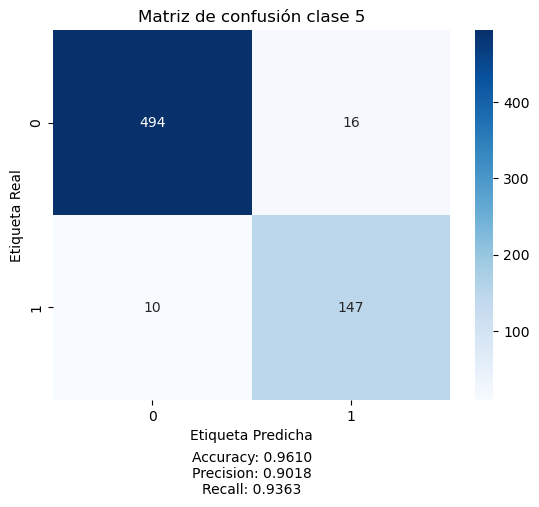

Class 5 statistics:
Accuracy 0.9610, Precision 0.9018, Recall 0.9363



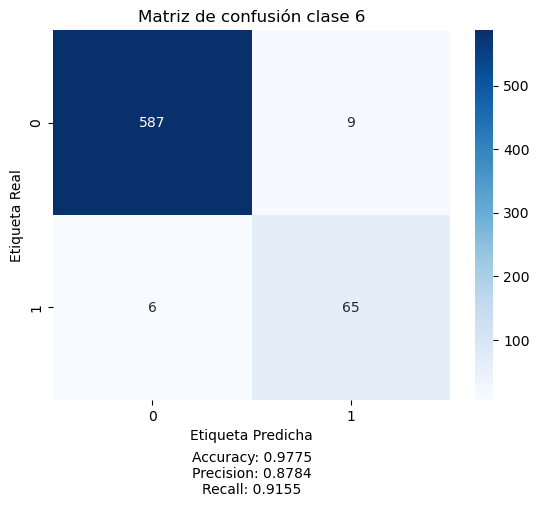

Class 6 statistics:
Accuracy 0.9775, Precision 0.8784, Recall 0.9155



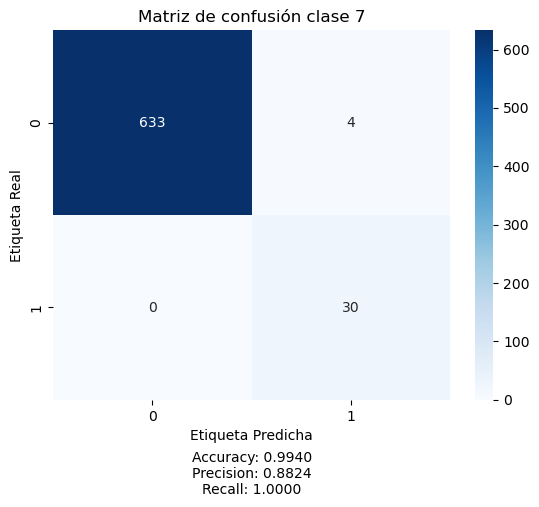

Class 7 statistics:
Accuracy 0.9940, Precision 0.8824, Recall 1.0000



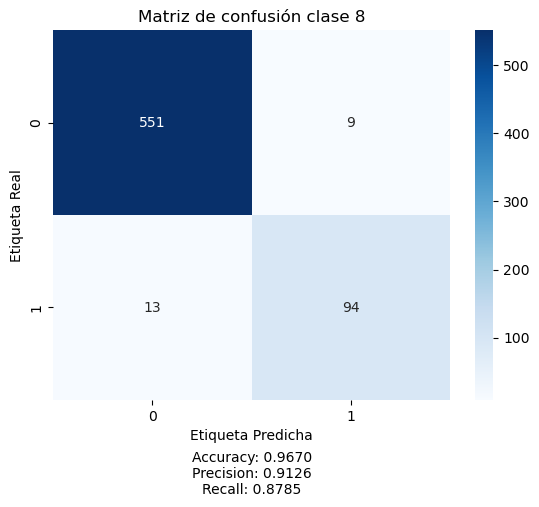

Class 8 statistics:
Accuracy 0.9670, Precision 0.9126, Recall 0.8785



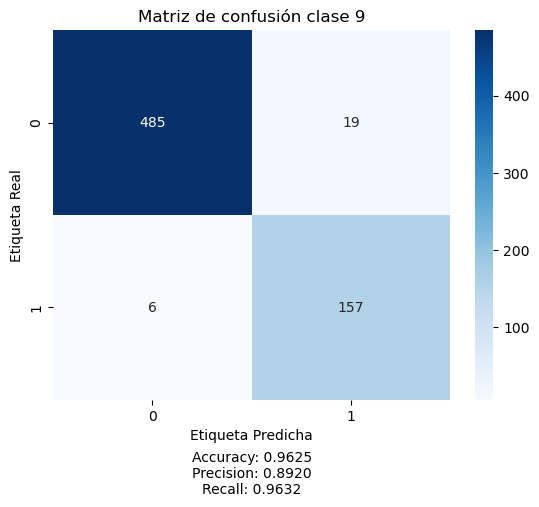

Class 9 statistics:
Accuracy 0.9625, Precision 0.8920, Recall 0.9632



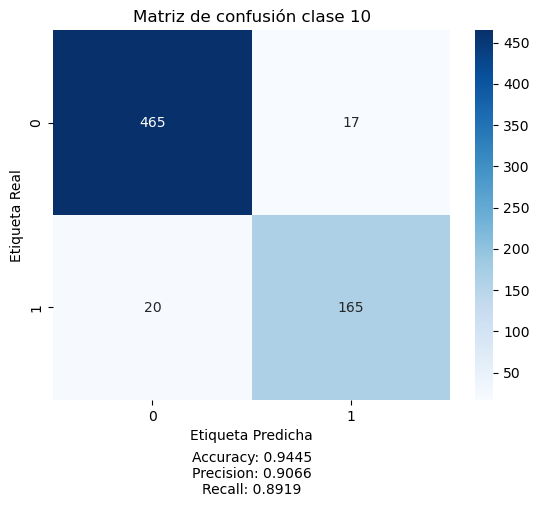

Class 10 statistics:
Accuracy 0.9445, Precision 0.9066, Recall 0.8919



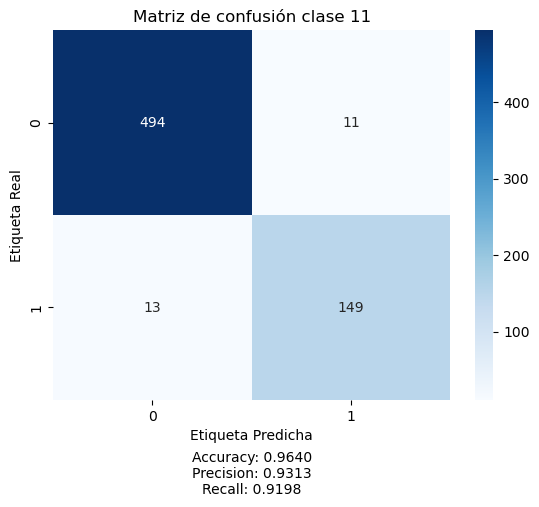

Class 11 statistics:
Accuracy 0.9640, Precision 0.9313, Recall 0.9198



In [28]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

data_batch = list(zip(*dataset_test[:]))

sel_maccs            = torch.FloatTensor(data_batch[-1])    
inputs, t_properties = data_batch[:-2], torch.cat(data_batch[-2])
z_properties         = model.forward(inputs, sel_maccs)

torch.set_printoptions(precision=2)
p_properties = torch.sigmoid(z_properties)

p_properties = p_properties.data.to('cpu').numpy()
t_properties = t_properties.data.to('cpu').numpy()

p_properties[p_properties<0.5]  = 0
p_properties[p_properties>=0.5] = 1

for c in range(11):
    y_true = t_properties[:,c]
    y_pred = p_properties[:,c]
    
    auc       = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall    = recall_score(y_true, y_pred)

    # Plotting the confusion matrix
    confusion = confusion_matrix(y_true=y_true,y_pred=y_pred)
    sns.heatmap(confusion, annot=True, cmap="Blues", fmt="d")
    plt.title("Matriz de confusión clase " + str(c+1))
    plt.xlabel("Etiqueta Predicha")
    plt.ylabel("Etiqueta Real")
    metrics_text = 'Accuracy: %.4f\nPrecision: %.4f\nRecall: %.4f' % (auc, precision, recall)
    plt.text(0.5, -0.2, metrics_text, horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes)

    plt.show()
    
    print('Class '+str(c+1)+' statistics:')
    print('Accuracy %.4f, Precision %.4f, Recall %.4f\n' %(auc, precision, recall))